In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data65


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

hand.inference.model


In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 122kB 8.4MB/s eta 0:00:01


In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

<h1 align="center">基于 PaddlePaddle框架 和 MNIST 数据集的手写数字识别</h1>

In [ ]:
import os
import math
import numpy as np
from PIL import Image
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt

2020-06-05 10:27:03,330-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-06-05 10:27:03,695-INFO: generated new fontManager


## 1 数据预处理

MNIST数据集包含70000张手写数字的灰度图片（黑底白字，如下图所示），其中每张图片包含 $28\times 28$ 个像素点。每张图片都有对应的标签，即图片对应的数字。数据集被分成两部分：包含60000张图片的训练数据集和包含10000张的测试数据集。

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/4db11e0e26444daabc62ee8a974f568d668329cd76fb421891db0aa3ed3aa93b" alt="01" width="50%" height="50%"/></div>
<div style="margin:1em"></div>

为了使模型能对黑底白字和白底黑字的手写数字的识别均有较高的准确率，就需要将黑底白字的图片进行转换。

PaddlePaddle 接口对提供的数据进行了归一化、居中等处理，即数据集中的灰度图片以 $28\times 28$  的矩阵数据类型存储，矩阵元素的取值范围在 $[-1,1]$之间。
根据上述描述，可以通过对原始数据集内每一个元素取相反数的操作，获得对应的白底黑字图片（如下图所示）。具体流程可描述为分别定义训练数据集和测试数据集的数据处理函数（或接口），将数据集（包括标签）一次读入，并对数据集中的项逐一取反，将生成的矩阵与原始矩阵进行拼接，获得了黑底白字和白底黑字的混合数据集

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/32641415c3b44dc8b1b14555dd769f0e9b9a9a0352a8497f9bd0d4f66c1f3465" alt="02" width="50%" height="50%"/></div>

In [ ]:
BUFF_SIZE = 512
BATCH_SIZE = 128

In [ ]:
def train_r():
    def reader():
        train_reader = paddle.batch(paddle.reader.shuffle(paddle.dataset.mnist.train(),buf_size=60000),batch_size=60000)
        train_data = next(train_reader())
        train_data=np.array(train_data)
        train_image=train_data[:,0]
        train_label=train_data[:,1]
        
        inverse_train_image=- train_image
        train_image=np.hstack((train_image, inverse_train_image))
        train_label=np.hstack((train_label, train_label))
        
        for i in range(120000):
            yield train_image[i], train_label[i]
    return reader

def test_r():
    def reader():
        test_reader = paddle.batch(paddle.reader.shuffle(paddle.dataset.mnist.test(),buf_size=10000),batch_size=10000)
        test_data = next(test_reader())
        test_data=np.array(test_data)
        test_image=test_data[:,0]
        test_label=test_data[:,1]
        
        inverse_test_image=- test_image
        test_image=np.hstack((test_image, inverse_test_image))
        test_label=np.hstack((test_label, test_label))

        for i in range(20000):
            yield test_image[i], test_label[i]
    return reader

## 2 数据加载

In [ ]:
train_reader = paddle.batch(paddle.reader.shuffle(reader=train_r(), buf_size=BUFF_SIZE),batch_size=BATCH_SIZE)
test_reader = paddle.batch(paddle.reader.shuffle(reader=test_r(), buf_size=BUFF_SIZE), batch_size=BATCH_SIZE)

## 3 网络配置

### 3.1 多层感知机(Multilayer Perceptron, MLP)

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/8ed463e6dd024d569eb1409cd8e593d2c3e8ca948007475ba69b407a33b4acbf" alt="01" width="50%" height="50%"/></div>

In [ ]:
# 定义多层感知器
def multilayer_perceptron(input):
    #请在此完成感知器模型定义
    hadden1 = fluid.layers.fc(input=input,size=100,act='relu')
    hadden2 = fluid.layers.fc(input=hadden1,size=100,act='relu')
    # hadden3 = fluid.layers.fc(input=hadden2,size=100,act='relu')
    # hadden4 = fluid.layers.fc(input=hadden3,size=100,act='relu')
    # hadden5 = fluid.layers.fc(input=hadden4,size=100,act='relu')
    # hadden6 = fluid.layers.fc(input=hadden5,size=100,act='relu')
    # hadden7 = fluid.layers.fc(input=hadden6,size=100,act='relu')
    prediction = fluid.layers.fc(input=hadden2,size=10,act='softmax')
    
    return prediction

### 3.2 Lente-5

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/a67573d213a747c5876671a7dcfc88635a9a475b9ffa45919d3c3ee9d24ff6eb" alt="01" width="100%" height="100%"/></div>

In [ ]:
def conv_pool(input, num_filters, filter_size, pool_size, pool_stride, act="relu"):
    """
    定义卷积池化层：
        含有一个卷积层和一个池化层
    Args：
        input —— 网络输入
        num_filters —— 卷积核的个数
        filter_size —— 卷积核的大小
        pool_size —— 池化核的大小
        pool_stride —— 池化的步长
        act —— 卷积层的激活函数

    Return:
        out -- 经过卷积池化后的特征图
    """
    conv_out = fluid.layers.conv2d(
        input=input,
        num_filters=num_filters,
        filter_size=filter_size,
        act=act)
    out = fluid.layers.pool2d(
        input=conv_out,
        pool_size=pool_size,
        pool_stride=pool_stride)
    return out

In [ ]:
# 定义卷积神经网络 CNN
def convolutional_neural_network(img):
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层

    Return:
        predict -- 分类的结果
    """
    # 第一个卷积-池化层
    # 使用20个5*5的滤波器，池化大小为2，池化步长为2，激活函数为Relu
    conv_pool_1 = conv_pool(
        input=img,
        filter_size=5,
        num_filters=20,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
#     drop = fluid.layers.dropout(x=conv_pool_1, dropout_prob=0.5)
    # 第二个卷积-池化层
    # 使用50个5*5的滤波器，池化大小为2，池化步长为2，激活函数为Relu
    conv_pool_2 = conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_2 = fluid.layers.batch_norm(conv_pool_2)
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为数字的个数10
    prediction = fluid.layers.fc(input=conv_pool_2, size=10, act='softmax')
    return prediction

### 3.3 VGG

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/4ff7247922d048fca1fba2749b12c6cad394978924234cca88dc976b4d9f89b3" alt="01" width="100%" height="100%"/></div>

In [ ]:
# 定义 VGG
def vgg_bn_drop(image, type_size):  
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt, # 具有[N，C，H，W]格式的输入图像
            pool_size=2,
            pool_stride=2,
            conv_num_filter=[num_filter] * groups, # 过滤器个数
            conv_filter_size=3, # 过滤器大小
            conv_act='relu',
            conv_with_batchnorm=True, # 表示在 Conv2d Layer 之后是否使用 BatchNorm
            conv_batchnorm_drop_rate=dropouts,# 表示 BatchNorm 之后的 Dropout Layer 的丢弃概率
            pool_type='max') # 最大池化

    conv1 = conv_block(image, 64, 2, [0.0, 0])
    conv2 = conv_block(conv1, 128, 2, [0.0, 0])
    conv3 = conv_block(conv2, 256, 3, [0.0, 0.0, 0])
    conv4 = conv_block(conv3, 512, 3, [0.0, 0.0, 0])
    conv5 = conv_block(conv4, 512, 3, [0.0, 0.0, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.0)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=type_size, act='softmax')
    return predict

### 3.4 ResNet

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/041771adbe144098a35186b21cb14be4dc9fdcb7557e40f5a9a918d7745e3295" alt="01" width="100%" height="100%"/></div>

In [ ]:
class DistResNet():
    def __init__(self, is_train=True):

        self.is_train = is_train
        self.weight_decay = 1e-4

    def net(self, input, class_dim=10):
    
        depth = [3, 3, 3]
        num_filters = [16, 32, 32]

        conv = self.conv_bn_layer(
            input=input, num_filters=16, filter_size=3, act='relu')
        conv = fluid.layers.pool2d(
            input=conv,
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        for block in range(len(depth)):
            for i in range(depth[block]):
                conv = self.bottleneck_block(
                    input=conv,
                    num_filters=num_filters[block],
                    stride=2 if i == 0 and block != 0 else 1)
                conv = fluid.layers.batch_norm(input=conv, act='relu')
        print(conv.shape)
        pool = fluid.layers.pool2d(
            input=conv, pool_size=4, pool_type='avg', global_pooling=True)
        stdv = 1.0 / math.sqrt(pool.shape[1] * 1.0)
        out = fluid.layers.fc(input=pool,
                              size=class_dim,
                              act="softmax",
                              param_attr=fluid.param_attr.ParamAttr(
                                  initializer=fluid.initializer.Uniform(-stdv,
                                                                        stdv),
                                  regularizer=fluid.regularizer.L2Decay(self.weight_decay)),
                              bias_attr=fluid.ParamAttr(
                                  regularizer=fluid.regularizer.L2Decay(self.weight_decay))
                              )
        return out

    def conv_bn_layer(self,
                      input,
                      num_filters,
                      filter_size,
                      stride=1,
                      groups=1,
                      act=None,
                      bn_init_value=1.0):
        conv = fluid.layers.conv2d(
            input=input,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False,
            param_attr=fluid.ParamAttr(regularizer=fluid.regularizer.L2Decay(self.weight_decay)))
        return fluid.layers.batch_norm(
                input=conv, act=act, is_test=not self.is_train,
                param_attr=fluid.ParamAttr(
                    initializer=fluid.initializer.Constant(bn_init_value),
                    regularizer=None))

    def shortcut(self, input, ch_out, stride):
        ch_in = input.shape[1]
        if ch_in != ch_out or stride != 1:
            return self.conv_bn_layer(input, ch_out, 1, stride)
        else:
            return input

    def bottleneck_block(self, input, num_filters, stride):
        conv0 = self.conv_bn_layer(
            input=input, num_filters=num_filters, filter_size=1, act='relu')
        conv1 = self.conv_bn_layer(
            input=conv0,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        conv2 = self.conv_bn_layer(
            input=conv1, num_filters=num_filters * 4, filter_size=1, act=None, bn_init_value=0.0)

        short = self.shortcut(input, num_filters * 4, stride)

        return fluid.layers.elementwise_add(x=short, y=conv2, act='relu')

In [ ]:
# 定义输入输出层
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')#单通道，28*28像素值
label = fluid.layers.data(name='label', shape=[1], dtype='int64')          #图片标签

In [ ]:
# 获取分类器
# predict = multilayer_perceptron(image)
predict = convolutional_neural_network(image)
# predict = vgg_bn_drop(image,10)
# model = DistResNet()
# predict = model.net(input=image, class_dim=10)
# 完成定义网络

In [ ]:
# 获取损失函数和准确率函数 
cost = fluid.layers.cross_entropy(input=predict, label=label)  #使用交叉熵损失函数,描述真实样本标签和预测概率之间的差值 交叉熵
avg_cost = fluid.layers.mean(cost)
acc = fluid.layers.accuracy(input=predict, label=label)

### 各种优化器的比较

<div class="imgs" align="center" ><img src="https://ai-studio-static-online.cdn.bcebos.com/9b4305ae0ac1499385e1986399fd31f8d1c3219c08b14dd9bbf3e062e4b79227" alt="01" width="50%" height="50%"/></div>

In [45]:
# 定义优化方法
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)   #使用Adam算法进行优化
# optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)   # SGDOptimizer算法
# optimizer = fluid.optimizer.Momentum(learning_rate = 0.001, momentum = 0.1) # Momentum算法
# optimizer = fluid.optimizer.Adamax(learning_rate = 0.001) # Adamax算法
opts = optimizer.minimize(avg_cost)

## 4 模型训练 & 模型评估

In [46]:
# 定义一个使用GPU的解析器
# place = fluid.CPUPlace()
use_gpu = True
place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

In [47]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

In [48]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

In [49]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost)
    plt.plot(iters, accs,color='green',label=lable_acc)
    plt.legend()
    plt.grid()
    plt.show()

Pass:0, Batch:0, Cost:2.86079, Accuracy:0.15625
Pass:0, Batch:100, Cost:0.13583, Accuracy:0.97656
Pass:0, Batch:200, Cost:0.12095, Accuracy:0.97656
Pass:0, Batch:300, Cost:0.02124, Accuracy:1.00000
Pass:0, Batch:400, Cost:0.05260, Accuracy:0.99219
Pass:0, Batch:500, Cost:0.05597, Accuracy:0.98438
Pass:0, Batch:600, Cost:0.09031, Accuracy:0.99219
Pass:0, Batch:700, Cost:0.08430, Accuracy:0.97656
Pass:0, Batch:800, Cost:0.08840, Accuracy:0.96875
Pass:0, Batch:900, Cost:0.11934, Accuracy:0.97656
Test:0, Cost:0.07099, Accuracy:0.97751
save models to work/hand.inference.model
Pass:1, Batch:0, Cost:0.13411, Accuracy:0.96094
Pass:1, Batch:100, Cost:0.07477, Accuracy:0.99219
Pass:1, Batch:200, Cost:0.01871, Accuracy:1.00000
Pass:1, Batch:300, Cost:0.01754, Accuracy:0.99219
Pass:1, Batch:400, Cost:0.14238, Accuracy:0.96875
Pass:1, Batch:500, Cost:0.02159, Accuracy:1.00000
Pass:1, Batch:600, Cost:0.12204, Accuracy:0.96875
Pass:1, Batch:700, Cost:0.11633, Accuracy:0.98438
Pass:1, Batch:800, Cost:

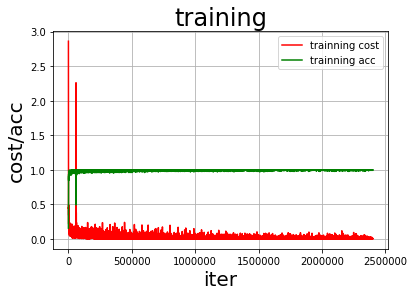

In [50]:
EPOCH_NUM = 20
model_save_dir = R"work/hand.inference.model"
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):  # 遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),  # 运行主程序
                                        feed=feeder.feed(data),  # 给模型喂入数据
                                        fetch_list=[avg_cost, acc])  # fetch 误差、准确率

        all_train_iter = all_train_iter + BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])

        # 每100个batch打印一次信息  误差、准确率
        if batch_id % 100 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 进行测试
    test_accs = []
    test_costs = []
    # 每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):  # 遍历test_reader
        test_cost, test_acc = exe.run(program=fluid.default_main_program(),  # 执行训练程序
                                      feed=feeder.feed(data),  # 喂入数据
                                      fetch_list=[avg_cost, acc])  # fetch 误差、准确率
        test_accs.append(test_acc[0])  # 每个batch的准确率
        test_costs.append(test_cost[0])  # 每个batch的误差

    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))  # 每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))  # 每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))

    # 保存模型
    # 如果保存路径不存在就创建
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    print('save models to %s' % (model_save_dir))
    fluid.io.save_inference_model(model_save_dir,  # 保存推理model的路径
                                  ['image'],  # 推理（inference）需要 feed 的数据
                                  [predict],  # 保存推理（inference）结果的 Variables
                                  exe)  # executor 保存 inference model
draw_train_process("training", all_train_iters, all_train_costs, all_train_accs, "trainning cost", "trainning acc")

## 5 模型预测

In [51]:
def load_image(file):
    im = Image.open(file).convert('L')                        #将RGB转化为灰度图像，L代表灰度图像，像素值在0~255之间
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
    # print(im)
    im = im / 255.0 * 2.0 - 1.0                               #归一化到【-1~1】之间
    return im

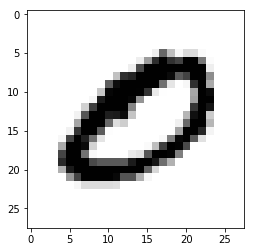

In [52]:
img_path=R'testdata/19939.png'
img = Image.open(img_path)
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像

In [53]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

In [57]:
# 加载数据并开始预测
with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,                                            #推理Program
     feed_target_names,                                            #是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。model_save_dir：模型保存的路径
                                                    infer_exe)     #infer_exe: 运行 inference model的 executor
    infer_path=img_path
    img = load_image(infer_path)

    results = infer_exe.run(program=inference_program,               #运行推测程序
                   feed={feed_target_names[0]: img},           #喂入要预测的img
                   fetch_list=fetch_targets)                   #得到推测结果,
    # 获取概率最大的label
    lab = np.argsort(results)                                  #argsort函数返回的是result数组值从小到大的索引值
    #print(lab)
    print("该图片的预测结果的label为: %d" % lab[0][0][-1])     #-1代表读取数组中倒数第一列

该图片的预测结果的label为: 0
